<a href="https://colab.research.google.com/github/Elieser1945/DeepLearning/blob/main/RNN_Model_TensorFlow_dengan_DeteksiSarkasme_json_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 **RNN Model TensorFlow dengan DeteksiSarkasme.json Dataset**

# Instalasi Library

In [1]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


# Import Library

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import numpy as np
import pandas as pd
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt


# Load Dataset

In [21]:
import json

data = []
with open('/content/DeteksiSarkasme.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

# Contoh lihat isi
print(data[0])


{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}


In [22]:
# Convert the loaded data to a DataFrame
df = pd.DataFrame(data)
display(df)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [8]:
headlines = [item['headline'] for item in data]
labels = [item['is_sarcastic'] for item in data]


# Pre Processing

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data Preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(headlines)  # Fit tokenizer on your data
sequences = tokenizer.texts_to_sequences(headlines)
X = pad_sequences(sequences, maxlen=100)  # Padding sequences to ensure uniform input size
y = np.array(labels)  # Labels as numpy array


In [10]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Bangun Model TensorFlow

In [11]:

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32),
                        input_length=100))
    model.add(LSTM(hp.Int('units', min_value=32, max_value=128, step=32)))  # LSTM layer
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (sarcastic or not)

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# Hyperparameter Tuning Dengan Keras Tuner

In [12]:
# Hyperparameter tuning with Keras Tuner
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=10, directory='my_dir', project_name='sarcasm_detection')
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Trial 30 Complete [00h 13m 27s]
val_accuracy: 0.8665294051170349

Best val_accuracy So Far: 0.8695245385169983
Total elapsed time: 03h 15m 40s


In [13]:
# Best model summary
best_model = tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │     1,898,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,996,993 (7.62 MB)

 Trainable params: 1,996,993 (7.62 MB)

 Non-trainable params: 0 (0.00 B)

# Latih Model

In [18]:
# Training the model with Google Colab's GPU
history = best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 120s 176ms/step - accuracy: 0.9739 - loss: 0.0762 - val_accuracy: 0.8560 - val_loss: 0.3715
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 140s 174ms/step - accuracy: 0.9900 - loss: 0.0310 - val_accuracy: 0.8538 - val_loss: 0.5235
Epoch 3/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 143s 175ms/step - accuracy: 0.9966 - loss: 0.0121 - val_accuracy: 0.8534 - val_loss: 0.7278
Epoch 4/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 143s 177ms/step - accuracy: 0.9983 - loss: 0.0065 - val_accuracy: 0.8431 - val_loss: 0.7599
Epoch 5/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 138s 171ms/step - accuracy: 0.9992 - loss: 0.0023 - val_accuracy: 0.8411 - val_loss: 0.9313
Epoch 6/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 145s 175ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.8403 - val_loss: 0.8941
Epoch 7/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 141s 173ms/step - accuracy: 0.9997 - loss: 0.0020 - val_accuracy: 0.8437 - val_loss: 0.9258
Epoch 8/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 144s 177ms/step - accuracy: 0.9995 -

# Evaluasi Model

In [14]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels


167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step


In [15]:
# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.90      0.89      2996
           1       0.87      0.83      0.85      2346

    accuracy                           0.87      5342
   macro avg       0.87      0.87      0.87      5342
weighted avg       0.87      0.87      0.87      5342



# Visulaisasi

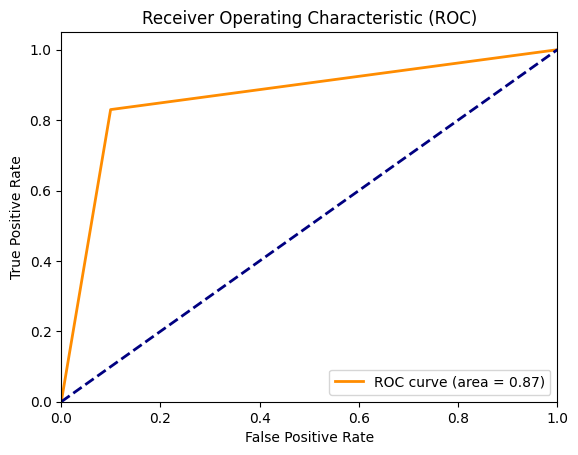

In [16]:
# AUC and ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


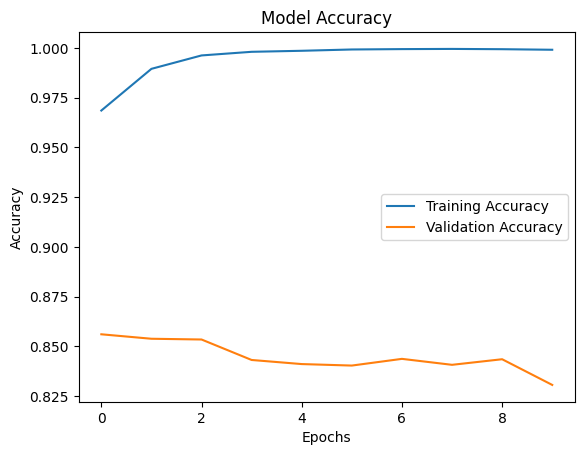

In [19]:
# Plotting accuracy and loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

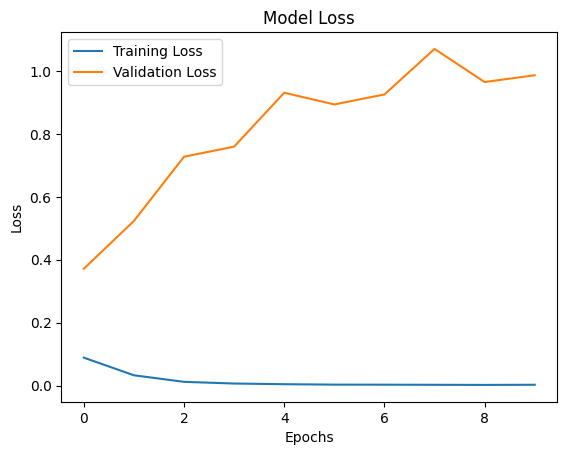

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()